In [13]:
# will autoupdate any of the packages imported:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import numpy as np
import pyclifford as pc
from numba import njit
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
import time
from multiprocess import Pool
import os
print("Number of CPUs: ", os.cpu_count())
print("Number of CPUs available: ", len(os.sched_getaffinity(0)))
print("Number of CPUs per task:", int(os.environ['SLURM_CPUS_PER_TASK']))
print("Number of CPUs on node:", int(os.environ['SLURM_CPUS_ON_NODE']))
num_cpus = len(os.sched_getaffinity(0))

Number of CPUs:  32
Number of CPUs available:  8
Number of CPUs per task: 8
Number of CPUs on node: 8


# Lib
Copied from `MIPT.py` to allow for more flexible development.

In [15]:
@njit
def qubit_pos(i, D = 1):
    """Generates a list of qubit positions corresponding to qudit i.

    Args:
        i (int): The qudit position.
        D (int, optional): The number of qubits per qudit. Defaults to 1.

    Returns:
        list: The list of qubit positions.
    """
    return [i * D + j for j in range(D)]

def random_clifford(circ, even = True, D = 1):
    """Adds a layer of random Clifford gates to the circuit.

    Args:
        circ (pc.circuit.Circuit): The circuit to add gates to.
        even (bool, optional): Whether to add gates starting with even or odd qudits. Defaults to True.
        D (int, optional): The number of qubits per qudit. Defaults to 1.
    
    Returns:
        None
    """
    N = circ.N
    assert N % D == 0
    L = int(N / D)

    for i in range(L // 2):
        if even:
            q1 = 2 * i
            q2 = q1 + 1
        else:
            q1 = 2 * i + 1
            q2 = (q1 + 1) % L
        circ.gate(*qubit_pos(q1, D), *qubit_pos(q2, D))

@njit
def generate_measurement_position(L, p, D = 1):
    """Generates a random list of positions to measure.

    Args:
        L (int): The number of qudits in the circuit.
        p (float): The probability of measuring each qudit.
        D (int, optional): The number of qubits per qudit. Defaults to 1.

    Returns:
        list: The list of qubit positions to measure.
    """
    positions = []
    for i in range(L):
        if np.random.rand()<p:
            positions.extend(qubit_pos(i, D))
    return positions

def random_measurement(circ, p, D = 1):
    """Adds a layer of random measurements to the circuit.

    Args:
        circ (pc.circuit.Circuit): The circuit to add measurements to.
        p (float): The probability of measuring each qudit.
        D (int, optional): The number of qubits per qudit. Defaults to 1.

    Returns:
        None
    """
    L = int(circ.N / D)
    pos = generate_measurement_position(L, p, D)
    if pos: # not empty
        circ.measure(*pos)

def create_circuit(L, depth, p, D = 1):
    """Creates a random Clifford circuit with random measurements.
    
    Args:
        L (int): The number of qudits in the circuit.
        depth (int): The number of time steps in the circuit.
        p (float): The probability of measuring each qudit.
        D (int, optional): The number of qubits per qudit. Defaults to 1.
    
    Returns:
        pc.circuit.Circuit: The random Clifford circuit.
    """
    N = L * D
    if p > 0:
        circ = pc.circuit.Circuit(N)
        for _ in range(depth):
            random_clifford(circ, even = True, D = D)
            random_measurement(circ, p, D)
            random_clifford(circ, even = False, D = D)
            random_measurement(circ, p, D)
    else:
        circ = pc.circuit.Circuit(N) # TODO: use tc.circuit.CliffordCircuit for greater speedup
        for _ in range(depth):
            random_clifford(circ, even = True, D = D)
            random_clifford(circ, even = False, D = D)
    return circ

def me_state(L, D = 1):
    """Creates a random maximally entangled state.

    Args:
        L (int): The number of qudits in the state.
        D (int, optional): The number of qubits per qudit. Defaults to 1.
    
    Returns:
        pc.stabilizer.StabilizerState: The maximally entangled state.
    """
    N = L * D
    state = pc.zero_state(N)
    circ = create_circuit(L, L // 2, 0, D)
    circ.forward(state)
    return state

def entropy(state, D = 1, A = None):
    """Calculates the bipartite entanglement entropy of the state.

    Args:
        state (pc.stabilizer.StabilizerState): The state to calculate the entropy of.
        D (int, optional): The number of qubits per qudit. Defaults to 1.
        A (list, optional): The list of qudit positions to calculate the entropy of. Defaults to None (first half of the qudits)

    Returns:
        float: The bipartite entanglement entropy.
    """
    N = state.N
    L = int(N / D)
    if A is None:
        A = [i for i in range(L // 2)]
    return state.entropy([j for i in A for j in qubit_pos(i, D)])

def bip_info(state, D = 1, recip_size = 8):
    """Calculates the bipartite mutual information of two opposite subsystems.

    Args:
        state (pc.stabilizer.StabilizerState): The state to calculate the mutual information of.
        D (int, optional): The number of qubits per qudit. Defaults to 1.
        recip_size (int, optional): The reciprocal size of the subsystems, in terms of L. Defaults to 8.
    
    Returns:
        float: The bipartite mutual information.
    """
    N = state.N
    L = int(N / D)
    assert recip_size > 2
    subsys_size = int(L / recip_size)
    subsys_1 = [i for i in range(subsys_size)]
    subsys_2 = [int(L / 2) + i for i in range(subsys_size)]
    return entropy(state, D, subsys_1) + entropy(state, D, subsys_2) - entropy(state, D, subsys_1 + subsys_2)

def trip_info(state, D = 1, recip_size = 4):
    """Calculates the negative tripartite mutual information of three adjacent subsystems.
    
    Args:
        state (pc.stabilizer.StabilizerState): The state to calculate the mutual information of.
        D (int, optional): The number of qubits per qudit. Defaults to 1.
        recip_size (int, optional): The reciprocal size of the subsystems, in terms of L. Defaults to 4.
    
    Returns:
        float: The negative tripartite mutual information.
    """
    N = state.N
    L = int(N / D)
    assert recip_size > 3

    subsys_size = int(L / recip_size)
    subsys_1 = [i for i in range(subsys_size)]
    subsys_2 = [i + subsys_size for i in range(subsys_size)]
    subsys_3 = [i + 2 * subsys_size for i in range(subsys_size)]

    info_1 = entropy(state, D, subsys_1) + entropy(state, D, subsys_2) + entropy(state, D, subsys_3)
    info_2 = entropy(state, D, subsys_1 + subsys_2) + entropy(state, D, subsys_2 + subsys_3) + entropy(state, D, subsys_3 + subsys_1)
    info_3 = entropy(state, D, subsys_1 + subsys_2 + subsys_3)
    return -info_1 + info_2 - info_3

def evolve_entropy(state, depth, p, D = 1):
    """Computes the bipartite entanglement entropy of the state under random time evolution.

    Args:
        state (pc.stabilizer.StabilizerState): The initial state.
        depth (int): The number of time steps.
        p (float): The probability of measuring each qudit.
        D (int, optional): The number of qubits per qudit. Defaults to 1.

    Returns:
        np.ndarray: An array of shape (depth + 1,) containing the bipartite entanglement entropies.
    """
    N = state.N
    L = int(N / D)
    entropies = [entropy(state, D)]
    for _ in range(depth):
        circ = create_circuit(L, 1, p, D)
        circ.forward(state)
        entropies.append(entropy(state, D))
    return np.array(entropies)

def evolve_entropies(L, depth, p, zero = True, shots = 10, D = 1, logging = True):
    """Computes an ensemble average version of evolve_entropy.

    Args:
        L (int): The number of qudits in the state.
        depth (int): The number of time steps.
        p (float): The probability of measuring each qudit.
        zero (bool, optional): Whether to start from the zero state. Defaults to True.
        shots (int, optional): The number of samples to average over. Defaults to 10.
        D (int, optional): The number of qubits per qudit. Defaults to 1.
        logging (bool, optional): Whether to display a progress bar. Defaults to True.
    
    Returns:
        np.ndarray: An array of shape (2, depth + 1) containing the mean and std of the bipartite entanglement entropies.
    """
    N = L * D
    entropies_raw = []
    if logging:
        for _ in tqdm(range(shots)):
            if zero:
                state = pc.zero_state(N)
            else:
                state = me_state(L, D)
            entropies_raw.append(evolve_entropy(state, depth, p, D))
    else:
        for _ in range(shots):
            if zero:
                state = pc.zero_state(N)
            else:
                state = me_state(L, D)
            entropies_raw.append(evolve_entropy(state, depth, p, D))
    
    entropies_raw = np.array(entropies_raw)
    entropies_mean = np.mean(entropies_raw, axis = 0)
    entropies_std = np.std(entropies_raw, axis = 0, ddof = 1) / np.sqrt(shots)
    return np.array([entropies_mean, entropies_std])


# Dev

## Bipartite mutual information

Benchmarking on 32 qubits, 10k shots:

* `multiprocess`, 32 CPUs - 0:57
* `multiprocess`, 4 CPUs - 2:45
* `multiprocess`, 2 CPUs - 4:55
* For loop - 8:10

32 qubits, 100 shots * 10 timesteps * 11 p-values:

* `multiprocess`, 8 CPUs - 0:21

32 qubits, 100 shots * 100 timesteps * 11 p-values:

* `multiprocess`, 8 CPUs - 0:53

32 qubits, 1000 shots * 10 timesteps * 11 p-values:

* `multiprocess`, 8 CPUs - 1:35

64 qubits, 100 shots * 10 timesteps * 11 p-values:

* `multiprocess`, 8 CPUs - 0:39

64 qubits, 100 shots * 100 timesteps * 11 p-values:

* `multiprocess`, 8 CPUs - 1:43

In [16]:
L = 64
depth = int(L / 2)
shots = 100
timesteps = 10
D = 1
N = L * D

In [17]:
def sample_trip(p):
    trips = []
    circ = create_circuit(L, depth, p, D = D)
    state = pc.zero_state(N)
    circ.forward(state)
    trips.append(trip_info(state, D = D))

    for _ in range(timesteps - 1):
        circ = create_circuit(L, 1, p, D = D)
        circ.forward(state)
        trips.append(trip_info(state, D = D))
    
    trips = np.array(trips)
    return np.mean(trips), trips[-1]

In [18]:
ps = np.linspace(0.155, 0.165, 11)
runs = np.repeat(ps, shots)

In [19]:
with Pool(num_cpus) as pool:
    result = pool.map(sample_trip, runs)

result = np.array(result)
result = np.reshape(result, (-1, shots, 2))
std = np.std(result[:, :, 1], axis = 1, ddof = 1)
result = np.mean(result, axis = 1)
result[:, 1] = std / np.sqrt(runs.shape[0])

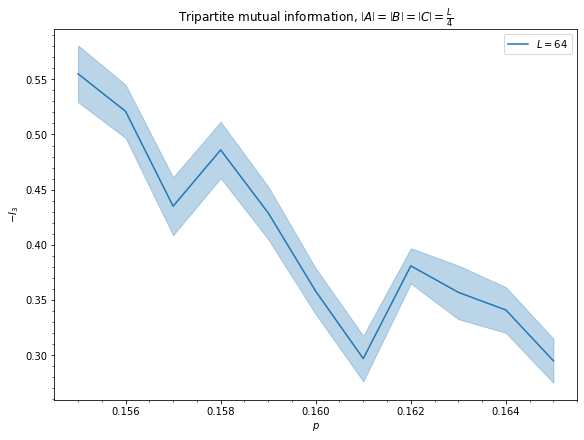

In [20]:
# stub = "clifford/figs/{}_{}_{}_{}_".format(L, depth, shots, D)
colors = sns.color_palette("tab10")
plt.subplots(figsize = (8, 6), layout = "constrained")
plt.plot(ps, result[:, 0], label = "$L={}$".format(L), color = colors[0])
plt.fill_between(ps, result[:, 0] - result[:, 1], result[:, 0] + result[:, 1], color = colors[0], alpha = 0.3)
plt.xlabel(r"$p$")
plt.ylabel(r"$-I_3$")
plt.title(r"Tripartite mutual information, $\left|A\right|=\left|B\right|=\left|C\right|=\frac{L}{4}$")
plt.legend(loc = "upper right")
plt.minorticks_on()
# plt.savefig(stub + "trip.png")